In [473]:
import pandas as pd
import optuna
from optuna.logging import get_logger
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
import logging

In [474]:
logging.basicConfig(filename='../data/log_file.log', level=logging.INFO)
logger = logging.getLogger(__name__)

In [475]:
def warn_with_log(message, category, filename, lineno, file=None, line=None):
    logger.warning(f'{filename}:{lineno}: {category.__name__}: {message}')

In [476]:
warnings.showwarning = warn_with_log
warnings.filterwarnings('always')

In [477]:
df_test = pd.read_csv('../data/test.csv')
df_train = pd.read_csv('../data/train.csv')

In [478]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [479]:
df_train.shape

(8693, 14)

In [480]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [481]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [482]:
print(df_train.isna().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [483]:
print(df_test.isna().sum())

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


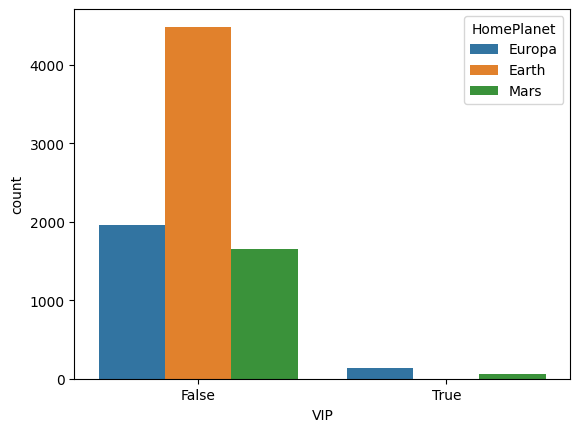

In [484]:
sb.countplot(data=df_train, x='VIP',
             hue='HomePlanet')
plt.show()

In [485]:
df_train['HomePlanet'] = df_train['HomePlanet'].fillna(pd.Series(np.where(df_train['VIP'] == True, 'Europa', 'Earth'), index=df_train.index))

In [486]:
cols_for_cryo_sleep = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_train['CryoSleep'] = df_train['CryoSleep'].fillna((df_train[cols_for_cryo_sleep] != 0.0).any(axis=1))

imputer = SimpleImputer(strategy='mean')
df_train[['Age']] = imputer.fit_transform(df_train[['Age']])

imputer = SimpleImputer(strategy='most_frequent')
df_train[['Cabin', 'VIP']] = imputer.fit_transform(df_train[['Cabin', 'VIP']])

In [487]:
df_train[['Deck', 'Num', 'Side']] = df_train['Cabin'].str.split('/', expand=True)
df_train = df_train.drop(columns=["Name", "Cabin", "Num"])

In [488]:
df_train['Destination'] = df_train['Destination'].fillna('Unknown')

In [489]:
df_VIP = df_train.loc[((df_train["VIP"] == True) & (df_train["CryoSleep"] == False))]
df_com = df_train.loc[((df_train["VIP"] == False) & (df_train["CryoSleep"] == False))]

for c in cols_for_cryo_sleep:
    mean_com = df_com[c].mean()
    mean_VIP = df_VIP[c].mean()
    df_train[c] = df_train.apply(lambda row: 0 if row['CryoSleep'] else (mean_com if not(row['VIP']) else mean_VIP) if pd.isnull(row[c]) else row[c], axis=1)

In [490]:
le = LabelEncoder()
df_train['Deck'] = le.fit_transform(df_train['Deck'])
df_train['Side'] = le.fit_transform(df_train['Side'])
df_train['HomePlanet'] = le.fit_transform(df_train['HomePlanet'])
df_train['Destination'] = le.fit_transform(df_train['Destination'])

df_train['VIP'] = df_train['VIP'].astype(int)
df_train['CryoSleep'] = df_train['CryoSleep'].astype(int)

In [491]:
listTransported = [False, True]
mapTransported = {i: listTransported.index(i) for i in listTransported}
df_train['Transported'] = df_train['Transported'].map(mapTransported)

In [492]:
passenger_ids = df_test['PassengerId'].copy()

df_train = df_train.drop(columns=["PassengerId"])
df_test = df_test.drop(columns=["PassengerId"])

df_test['HomePlanet'] = df_test['HomePlanet'].fillna(pd.Series(np.where(df_test['VIP'] == True, 'Europa', 'Earth'), index=df_test.index))

cols_for_cryo_sleep = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_test['CryoSleep'] = df_test['CryoSleep'].fillna((df_test[cols_for_cryo_sleep] != 0.0).any(axis=1))

imputer = SimpleImputer(strategy='mean')
df_test[['Age']] = imputer.fit_transform(df_test[['Age']])

imputer = SimpleImputer(strategy='most_frequent')
df_test[['Cabin', 'VIP']] = imputer.fit_transform(df_test[['Cabin', 'VIP']])

df_test[['Deck', 'Num', 'Side']] = df_test['Cabin'].str.split('/', expand=True)
df_test = df_test.drop(columns=["Name", "Cabin", "Num"])

df_test['Destination'] = df_test['Destination'].fillna('Unknown')

df_VIP = df_test.loc[((df_test["VIP"] == True) & (df_test["CryoSleep"] == False))]
df_com = df_test.loc[((df_test["VIP"] == False) & (df_test["CryoSleep"] == False))]

for c in cols_for_cryo_sleep:
    mean_com = df_com[c].mean()
    mean_VIP = df_VIP[c].mean()
    df_test[c] = df_test.apply(lambda row: 0 if row['CryoSleep'] else (mean_com if not(row['VIP']) else mean_VIP) if pd.isnull(row[c]) else row[c], axis=1)

le = LabelEncoder()
df_test['Deck'] = le.fit_transform(df_test['Deck'])
df_test['Side'] = le.fit_transform(df_test['Side'])
df_test['HomePlanet'] = le.fit_transform(df_test['HomePlanet'])
df_test['Destination'] = le.fit_transform(df_test['Destination'])

df_test['VIP'] = df_test['VIP'].astype(int)
df_test['CryoSleep'] = df_test['CryoSleep'].astype(int)

In [493]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int32  
 1   CryoSleep     8693 non-null   int32  
 2   Destination   8693 non-null   int32  
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int32  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   int64  
 11  Deck          8693 non-null   int32  
 12  Side          8693 non-null   int32  
dtypes: float64(6), int32(6), int64(1)
memory usage: 679.3 KB


In [494]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   int32  
 1   CryoSleep     4277 non-null   int32  
 2   Destination   4277 non-null   int32  
 3   Age           4277 non-null   float64
 4   VIP           4277 non-null   int32  
 5   RoomService   4277 non-null   float64
 6   FoodCourt     4277 non-null   float64
 7   ShoppingMall  4277 non-null   float64
 8   Spa           4277 non-null   float64
 9   VRDeck        4277 non-null   float64
 10  Deck          4277 non-null   int32  
 11  Side          4277 non-null   int32  
dtypes: float64(6), int32(6)
memory usage: 300.9 KB


In [495]:
X = df_train.drop('Transported', axis=1)
y = df_train['Transported']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [496]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    model = CatBoostClassifier(**param, silent=True)
    cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    model.fit(X_train, y_train, cat_features=cat_features)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

In [497]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

In [498]:
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
 Value:  0.772857964347326
 Params: 
    objective: Logloss
    colsample_bylevel: 0.030803220494325517
    depth: 8
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.36501944619003657


In [499]:
best_params = study.best_trial.params
model = CatBoostClassifier(**best_params, silent=True)
model.fit(X_train, y_train)

In [500]:
predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f'Точность модели CatBoost Optuna на валидационных данных: {accuracy}')

Точность модели CatBoost Optuna на валидационных данных: 0.7676825761932144


In [501]:
model_test_predictions = model.predict(df_test)
model_test_predictions = (model_test_predictions == 1)

In [502]:
model_submission = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': model_test_predictions})
model_submission.to_csv('../data/optuna_submission.csv', index=False)
print('Файл optuna_submission.csv успешно сохранен.')

Файл optuna_submission.csv успешно сохранен.


In [503]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)

RandomForestClassifier()

In [504]:
base_predictions = base_model.predict(X_val)
base_accuracy = accuracy_score(y_val, base_predictions)
print(f'Точность базового классификатора на валидационных данных: {base_accuracy}')

Точность базового классификатора на валидационных данных: 0.7786083956296722


In [505]:
model = CatBoostClassifier(verbose=0)

In [506]:
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
model.fit(X_train, y_train, cat_features=cat_features)

In [507]:
predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f'Точность модели CatBoost на валидационных данных: {accuracy}')

Точность модели CatBoost на валидационных данных: 0.7912593444508338


In [508]:
base_test_predictions = base_model.predict(df_test)
model_test_predictions = model.predict(df_test)

base_test_predictions = (base_test_predictions == 1)
model_test_predictions = (model_test_predictions == 1)

In [509]:
base_submission = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': base_test_predictions})
base_submission.to_csv('../data/forest_submission.csv', index=False)
print('Файл forest_submission.csv успешно сохранен.')

model_submission = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': model_test_predictions})
model_submission.to_csv('../data/catboost_submission.csv', index=False)
print('Файл catboost_submission.csv успешно сохранен.')

Файл forest_submission.csv успешно сохранен.
Файл catboost_submission.csv успешно сохранен.
